In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [3]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = "FedEM_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 40

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 273.90it/s]


===> Initializing clients..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:54<00:00,  1.48it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.221% |Test Loss: 2.290 | Test Acc: 12.547% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [4]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [17]:
selection = 2
name = ['fedavg', 'fedavg_adv', 'fedEM','fedEM_adv']
exp_names = ['weights/neurips/cifar/local_tuning_03/' + name[selection]+'/']
exp_modes = ['FedAvg','FedAvg','FedEM','FedEM']

tunes= [0,5,10,20,30,40]

train_item = 'train_client_weights.npy'

In [18]:
num_victims = 25
num_exp = len(tunes) + 1
# Set Up Dictionaries -- list holds the adversary idx
exp_logs = {}

for j in range(num_exp):
    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None
        
        logs_adv += [adv_dict]
    
    exp_logs[j] = copy.deepcopy(logs_adv)


In [19]:
j = 0
# Inter Boundary Distance Metric
custom_batch_size = 500

print('processing file', exp_names[j], '...')
setting = exp_modes[selection]

if setting == 'FedAvg':

    args_.method = 'FedAvg'
    args_.n_learners= 1

    aggregator, clients = dummy_aggregator(args_, num_user=40)

    args_.save_path = exp_names[j]
    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]

    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0[0]*weights_h[0][key]
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]


elif setting == 'FedEM':

    args_.method = 'FedEM'
    args_.n_learners= 3

    aggregator, clients = dummy_aggregator(args_, num_user=40)

    args_.save_path = exp_names[j]

    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]

    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]    

victim_idxs = range(num_victims)

for adv_idx in victim_idxs:
    print("\t Adv idx:", adv_idx)
    # Perform Attacks
    dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
    batch_size = min(custom_batch_size, dataloader.y_data.shape[0])

    t1 = Transferer(models_list=models_test, dataloader=dataloader)
    t1.generate_victims(victim_idxs)

    t1.atk_params = PGD_Params()
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                   target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)

    t1.generate_advNN(adv_idx)
    t1.generate_xadv(atk_type = "pgd")
    t1.send_to_victims(victim_idxs)
    # t1.check_empirical_metrics(orig_flag = True)

    # Log Performance
    exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
    exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
    exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
    exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
    exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

    # Miss attack
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                   target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
    t1.generate_xadv(atk_type = "pgd")
    t1.send_to_victims(victim_idxs)
    exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
    exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


del models_test

processing file weights/neurips/cifar/local_tuning_03/fedEM/ ...
==> Clients initialization..
===> Building data iterators..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 352.46it/s]


===> Initializing clients..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:33<00:00,  2.37it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.221% |Test Loss: 2.290 | Test Acc: 12.547% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24


In [20]:
for j in range(1, len(tunes)):
    
    print("\nRunning Exp Tunes:", j, "out of", len(tunes)-1)
    
    # load local model
    aggregator.load_state_local(exp_names[0],tunes[j])
    
    # model_weights - this now exists from prior 

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    if setting == 'FedEM':
        
        client_idx = 0    
        for (w0,w1,w2) in model_weights:
            # first make the model with empty weights
            hypotheses = aggregator.clients[client_idx].learners_ensemble.learners
            
             # obtain the state dict for each of the weights 
            weights_h = []

            for h in hypotheses:
                weights_h += [h.model.state_dict()]
            
            new_model = copy.deepcopy(hypotheses[0].model)
            new_model.eval()
            new_weight_dict = copy.deepcopy(weights_h[0])
            for key in weights_h[0]:
                new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
            new_model.load_state_dict(new_weight_dict)
            models_test += [new_model] 

            client_idx += 1
    
    elif setting == 'FedAvg':
        
        client_idx = 0 
        for (w0) in model_weights:
            hypotheses = aggregator.clients[client_idx].learners_ensemble.learners
            
             # obtain the state dict for each of the weights 
            weights_h = []

            for h in hypotheses:
                weights_h += [h.model.state_dict()]
            
            # first make the model with empty weights
            new_model = copy.deepcopy(hypotheses[0].model)
            new_model.eval()
            new_weight_dict = copy.deepcopy(weights_h[0])
            for key in weights_h[0]:
                new_weight_dict[key] = w0[0]*weights_h[0][key]
            new_model.load_state_dict(new_weight_dict)
            models_test += [new_model]
            
            client_idx += 1
            
    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])

        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)

        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test


Running Exp Tunes: 1 out of 5
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24

Running Exp Tunes: 2 out of 5
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24

Running Exp Tunes: 3 out of 5
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16

In [21]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(tunes)):
    victim_idxs = range(num_victims)
    
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [22]:
# Edit desired data
x = tunes
# Acc
y_acc = []
y_robust = []
y_target = []

y_acc_std = []
y_robust_std = []
y_target_std = []

for i in range(len(tunes)):
    y_acc += [np.mean(np.diagonal(orig_acc[i]))]
    y_robust += [avg_nondiag(adv_miss[i])]
    y_target += [avg_nondiag(adv_target[i])]
    
    y_acc_std += [np.std(orig_acc[i])]
    y_robust_std += [np.std(adv_miss[i])]
    y_target_std += [np.std(adv_target[i])]
    
print('y_acc', y_acc)
print('y_robust', y_robust)
print('y_target', y_target)

print('y_accstd', y_acc_std)
print('y_robuststd', y_robust_std)
print('y_targetstd', y_target_std)

y = [y_acc, y_robust, y_target]

y_acc [0.731652500629425, 0.7285501337051392, 0.7279410529136657, 0.7205920195579529, 0.7231180214881897, 0.7200403761863708]
y_robust [0.08441115370641152, 0.08244014559158434, 0.08535543244797736, 0.08456570373770471, 0.09212726582307368, 0.09000390632543713]
y_target [0.4811609805840999, 0.45953940947540106, 0.46292498134076593, 0.45009810738265515, 0.44028621757092573, 0.44389570952393115]
y_accstd [0.12723024099132044, 0.11697591750708491, 0.11506326761214712, 0.11443479432568064, 0.1149798108080663, 0.11611846947481436]
y_robuststd [0.11284846668808486, 0.10357275575010276, 0.10664505159627248, 0.10247227668404546, 0.1091829851353578, 0.11286033284466726]
y_targetstd [0.27895936730374504, 0.2650802029467431, 0.2606096990065189, 0.263089516555189, 0.264874308628841, 0.25995800714483774]


In [26]:
# Bad learning rate alpha = 0.01
# FedAvg

y_acc_fedavg = [0.7759524305661519, 0.7291629274686178, 0.7039053002993266, 0.7122286359469095, 0.7104225118954977]
y_robust_fedavg = [0.00367321710412701, 0.08055228201583738, 0.19223911974667793, 0.23761653060625706, 0.24973058150637717]
y_target_fedavg = [0.75438867410024, 0.3948804363253571, 0.24475289206020534, 0.19235339586489966, 0.17711720772841502]

# y_acc_fedavg = [0.8024801278114319, 0.8186887025833129, 0.8210506749153137, 0.823288996219635, 0.8198965668678284, 0.8216733336448669]
# y_robust_fedavg = [0.0013279709126800298, 0.0016851752845104785, 0.0017928260165111472, 0.002407410154507185, 0.0035432526368337374, 0.003222342641868939]
# y_target_fedavg = [0.8653120350837707, 0.8387157781918844, 0.8275840658942858, 0.8039193308353424, 0.7921642944961786, 0.7844493915140629]

std_acc_fedavg = [0.046451901353091414, 0.06770970711489004, 0.0729392457997499, 0.07788053655777073, 0.08543947125423353]
std_robust_fedavg = [0.0027679625569241666, 0.002845565597024808, 0.016305328089403295, 0.010137072819426425, 0.008578576738116583]
std_target_fedavg = [0.06219245113237429, 0.07138078673537758, 0.07368986421834675, 0.13965118980369712, 0.1186909613610819]

# std_acc_fedavg = [0.046451901353091414, 0.06770970711489004, 0.0729392457997499, 0.07788053655777073, 0.08240618793934032, 0.08543947125423353]
# std_robust_fedavg = [0.0027679625569241666, 0.002845565597024808, 0.016305328089403295, 0.010137072819426425, 0.0051716226894147005, 0.008578576738116583]
# std_target_fedavg = [0.06219245113237429, 0.07138078673537758, 0.07368986421834675, 0.13965118980369712, 0.14663591888779498, 0.1186909613610819]


# FedAvg- Adv
y_acc_fedavg_adv = [0.7515561739603679, 0.7952017744382223, 0.7938427130381266, 0.7929713209470113, 0.7065970281759898]
y_robust_fedavg_adv = [0.1726070836186409, 0.2053508875625474, 0.22123815138779934, 0.23938029557466506, 0.389599847084]
y_target_fedavg_adv = [0.4110386868317922, 0.35708707925819216, 0.3233843540151914, 0.2935645662957714, 0.09727491667006342]

# y_acc_fedavg_adv = [0.7575816202163697, 0.8110862970352173, 0.8279608607292175, 0.8280265736579895, 0.8317008996009827, 0.8291340661048889]
# y_robust_fedavg_adv = [0.2621356379985809, 0.28919790356109537, 0.3041558703190337, 0.315389868405958, 0.32036962704733013, 0.32484849395851295]
# y_target_fedavg_adv = [0.324968678355217, 0.29481395214485623, 0.27213243586942554, 0.25433389875184126, 0.23405591753389066, 0.23022493643841396]

std_acc_fedavg_adv = [0.05230822717911711, 0.12320461366314994, 0.14228104791579646, 0.15762042255846784, 0.17587982055974818]
std_robust_fedavg_adv = [0.06128776966173811, 0.08964471028547051, 0.1045532479537106, 0.11273024725062078, 0.1235560151381172]
std_target_fedavg_adv = [0.10075187395799172, 0.15142756573668778, 0.16448876535333615, 0.1736551684420754, 0.17538980205916233]

# std_acc_fedavg_adv = [0.05230822717911711, 0.12320461366314994, 0.14228104791579646, 0.15762042255846784, 0.17117533966611473, 0.17587982055974818]
# std_robust_fedavg_adv = [0.06128776966173811, 0.08964471028547051, 0.1045532479537106, 0.11273024725062078, 0.1238070963330395, 0.1235560151381172]
# std_target_fedavg_adv = [0.10075187395799172, 0.15142756573668778, 0.16448876535333615, 0.1736551684420754, 0.1757227803438526, 0.17538980205916233]


# FedEM
y_acc_fedem = [0.7722717265288035, 0.7562055726846059, 0.762859332561493, 0.761041259765625, 0.7655805905659994]
y_robust_fedem = [0.0522492538077821, 0.18729588588721108, 0.2313245390573966, 0.24343840520529225, 0.2451879919228283]
y_target_fedem = [0.49059560970756516, 0.25791059803758243, 0.21236735042639548, 0.19793031866656852, 0.18422645021781284]

# y_acc_fedem = [0.8148318457603455, 0.7954144525527954, 0.7961630511283875, 0.795313184261322, 0.8019865679740906, 0.8023530721664429]
# y_robust_fedem = [0.05175969710883995, 0.048117646684792514, 0.05106290290791852, 0.050766055621982865, 0.05095332903942714, 0.04874994841675895]
# y_target_fedem = [0.5112699501806249, 0.505635612498348, 0.4979948262870312, 0.48682648116722704, 0.47521309632187086, 0.47937073664429286]

std_acc_fedem = [0.11018969788595015, 0.10284149687593828, 0.10180973748586113, 0.10161786227897071, 0.10525150205994076]
std_robust_fedem = [0.05120292442782499, 0.05619442311940309, 0.058010975711868945, 0.057189999130470424, 0.055865062891412555]
std_target_fedem = [0.26467385659713644, 0.25986771585834506, 0.26516827319593617, 0.2599362451330682, 0.2597012177488558]

# std_acc_fedem = [0.11018969788595015, 0.10284149687593828, 0.10180973748586113, 0.10161786227897071, 0.10242251456855184, 0.10525150205994076]
# std_robust_fedem = [0.05120292442782499, 0.05619442311940309, 0.058010975711868945, 0.057189999130470424, 0.05613639136420067, 0.055865062891412555]
# std_target_fedem = [0.26467385659713644, 0.25986771585834506, 0.26516827319593617, 0.2599362451330682, 0.2644602474018424, 0.2597012177488558]

# FedEM - Adv
y_acc_fedem_adv = [0.7667379101117452, 0.7582960565884908, 0.7554788966973622, 0.7609592616558075, 0.7551505009333292]
y_robust_fedem_adv = [0.3074547937161278, 0.3337518439842281, 0.3375404459651795, 0.3410442241962635, 0.3462552427927075]
y_target_fedem_adv = [0.2127153437964661, 0.18047826879968246, 0.17367599169621994, 0.17415346957277505, 0.1681970478153263]

# y_acc_fedem_adv  =[0.784814202785492, 0.7907055473327637, 0.7931161999702454, 0.7957576513290405, 0.793544955253601, 0.7933079218864441]
# y_robust_fedem_adv =[0.3950925918047627, 0.41131138041615484, 0.4145790681367119, 0.41169829399635394, 0.40672679007053375, 0.4043341669688622]
# y_target_fedem_adv = [0.15312378746379787, 0.15353283130098133, 0.1487095224314059, 0.14598273868284498, 0.14785126963475098, 0.14734372293421377]

std_acc_fedem_adv = [0.14821825315264997, 0.14089471483233845, 0.14443493500086302, 0.15000199971610273, 0.16102799945263943]
std_robust_fedem_adv = [0.12200977990004429, 0.12422707671927304, 0.12780524417590905, 0.12937081975620476, 0.13370668154749651]
std_target_fedem_adv = [0.13522812788162256, 0.13549781533760588, 0.13479026895705132, 0.13669298459177945, 0.14223876956435982]

# std_acc_fedem_adv = [0.14821825315264997, 0.14089471483233845, 0.14443493500086302, 0.15000199971610273, 0.15728735446046585, 0.16102799945263943]
# std_robust_fedem_adv = [0.12200977990004429, 0.12422707671927304, 0.12780524417590905, 0.12937081975620476, 0.13135140139612853, 0.13370668154749651]
# std_target_fedem_adv = [0.13522812788162256, 0.13549781533760588, 0.13479026895705132, 0.13669298459177945, 0.14140704499877998, 0.14223876956435982]
# # 

Text(0.5, 1.0, 'CIFAR-10 Local Tuning Effect (Adv.)')

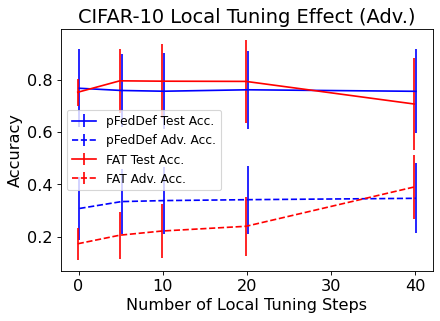

In [34]:
x = [0,5,10,20,40]

y2 = [y_acc_fedavg_adv, y_robust_fedavg_adv]
y1 = [y_acc_fedem_adv, y_robust_fedem_adv]

y2_std = [std_acc_fedavg_adv, std_robust_fedavg_adv]
y1_std = [std_acc_fedem_adv, std_robust_fedem_adv]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14.5}

plt.rc('font', **font)


names1 = ['pFedDef Test Acc.', 'pFedDef Adv. Acc.']
names2 = ['FAT Test Acc.', 'FAT Adv. Acc.']
colors = ['b','r']
types = ['-', '--']

plt.figure(figsize=(6, 4), dpi=80)
offset = 0.1

for i in range(len(names1)):
    plt.errorbar(np.array(x) + offset,y1[i],y1_std[i], label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names1)):
    plt.errorbar(np.array(x) - offset,y2[i],y2_std[i],label= names2[i], linestyle = types[i], color = colors[1])
#     plt.plot(x,y2[i], linestyle = types[i], color = colors[1])

plt.legend(frameon=True, loc = 'best', prop={'size':11})
plt.xlim();
# plt.ylim(0, 1.0);
plt.xlabel('Number of Local Tuning Steps')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 Local Tuning Effect (Adv.)")


Text(0.5, 1.0, 'CIFAR-10 Local Tuning Effect (Benign)')

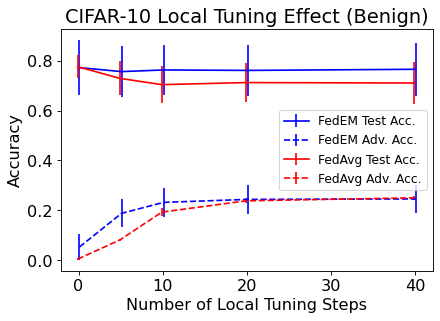

In [35]:
x = [0,5,10,20,40]

y2 = [y_acc_fedavg, y_robust_fedavg]
y1 = [y_acc_fedem, y_robust_fedem]

y2_std = [std_acc_fedavg, std_robust_fedavg]
y1_std = [std_acc_fedem, std_robust_fedem]


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14.5}

plt.rc('font', **font)


names1 = ['FedEM Test Acc.', 'FedEM Adv. Acc.']
names2 = ['FedAvg Test Acc.', 'FedAvg Adv. Acc.']
colors = ['b','r']
types = ['-', '--']

plt.figure(figsize=(6, 4), dpi=80)


for i in range(len(names1)):
    plt.errorbar(np.array(x) + offset,y1[i],y1_std[i], label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names1)):
    plt.errorbar(np.array(x) - offset,y2[i],y2_std[i],label= names2[i], linestyle = types[i], color = colors[1])
#     plt.plot(x,y2[i], linestyle = types[i], color = colors[1])


plt.legend(frameon=True, loc = 'best', prop={'size':11})
plt.xlim();
# plt.ylim(0, 1.0);
plt.xlabel('Number of Local Tuning Steps')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 Local Tuning Effect (Benign)")
